In [1]:
import os
import sys
import uuid
import math
import json
import time
import random
import more_itertools
from itertools import groupby
from tqdm.notebook import tqdm

import cv2

sys.path.insert(0, os.path.abspath(".."))
sys.path.insert(0, os.path.abspath("."))

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import albumentations as aug

from typing import Tuple
from hashlib import md5
from pathlib import Path
from collections import Counter

from datasetutils.feature_wrappers import (
    _int64_feature, _int64_list_feature, _bytes_list_feature, 
    _string_feature, _float_list_feature,_bytes_feature)

from training.training_utils import  load_model_profile, img_load, img_save, dtype_map
from training.lr_utils import cosine_decay_with_warmup

In [2]:
tf.__version__

'2.8.0'

In [3]:
GPU_IS_AVAILABLE = tf.test.is_gpu_available()

In [4]:
# base folders for data and models storage
DATASETS_BASE_PATH = "/media/datasets"
MODELS_BASE_PATH = "/media/models"

In [5]:
# TF devices
IO_DEVICE = "CPU:0" 
TRAINING_DEVICE = "GPU:0" if GPU_IS_AVAILABLE else "CPU:0"

## Dataset parameters

In [6]:
# labelling

CHARACTERS = [" ","0","1","2","3","4","5","6","7","8","9",",","/","*","+","-","%","=",".",":",";","p"]
DECODE_SYMBOL = {i : CHARACTERS[i] for i in range(len(CHARACTERS))}
ENCODE_SYMBOL = {val: key for key, val in DECODE_SYMBOL.items()}


def decode_symbol(i: int):
    return DECODE_SYMBOL[i]

def encode_symbol(i: str):
    return ENCODE_SYMBOL[i]


# # Mapping characters to integers
# char_to_num = tf.keras.layers.StringLookup(
#     vocabulary=list(CHARACTERS), mask_token=None
# )

# # Mapping integers back to original characters
# num_to_char = tf.keras.layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

# source images media path
MEDIA_PATH = f'{DATASETS_BASE_PATH}/digits/classification/v1/target/img'

# print("Number of unique characters: ", len(CHARACTERS))
# print("Characters: ", CHARACTERS)

In [7]:
# character\symbol parameters
CHR_MIN_WIDTH = 10
CHR_MAX_WIDTH = 32
CHR_MIN_HEIGTH = 20
CHR_MAX_HEIGTH = 32
CHR_MIN_PADDING = 3
CHR_MAX_PADDING = 10
CHR_STROKE_PROB = 0.2
CHR_STROKE_MIN_THICKNESS = 1
CHR_STROKE_MAX_THICKNESS = 5


# target image parameters
TARGET_MAX_CHARACTERS = 10
TARGET_HEIGTH = 32
TARGET_WIDTH = TARGET_HEIGTH * TARGET_MAX_CHARACTERS
TARGET_CHANNELS = 3
TARGET_SHAPE = (TARGET_HEIGTH, TARGET_WIDTH, TARGET_CHANNELS)


# dataset parameters
DATASET_NAME = "digit_ocr"
DATASET_VERSION = 'v1'
DATASET_TASK = 'detection'
DATASET_PATH = f"{DATASETS_BASE_PATH}/{DATASET_NAME}/{DATASET_VERSION}/"
DATASET_SIZE = 6000
DATASET_TRAIN_SIZE = .80
DATASET_VAL_SIZE   = .10
DATASET_TEST_SIZE  = .10
DATASET_REPEAT = False
DATASET_USE_AUG = False
DATASET_DTYPE = tf.float32
DATASET_COMPRESSION = 0
DATASET_IMG_SHAPE = TARGET_SHAPE


# source data, shape vary
SOURCE_DIR_PATH = os.path.join(DATASET_PATH, f'source/')
SOURCE_IMG_PATH = os.path.join(SOURCE_DIR_PATH, f'img/')
SOURCE_LABELS_PATH =  os.path.join(SOURCE_DIR_PATH, f'labels/')


# target data path
TARGET_DIR_PATH = os.path.join(DATASET_PATH, f'target/')
TARGET_IMG_PATH = os.path.join(TARGET_DIR_PATH, 'img/')
TARGET_LABELS_PATH = os.path.join(TARGET_DIR_PATH, 'labels/')


# target tfrecord folder path
TFRECORD_DIR_PATH = os.path.join(TARGET_DIR_PATH, f'tfrecord/')
TFRECORD_COMPRESSION_LEVEL = 5

# tfrecord files path
DATASET_TRAIN_PATH = os.path.join(TFRECORD_DIR_PATH, 'train.tfrecord')
DATASET_VAL_PATH = os.path.join(TFRECORD_DIR_PATH, 'val.tfrecord')
DATASET_TEST_PATH = os.path.join(TFRECORD_DIR_PATH, 'test.tfrecord')


# split parameters for training and evaluation
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.0
TEST_SPLIT = 0.2

dataset = None


In [8]:
def build_dataset_structure(ds_path=DATASET_PATH):
    
    # base folder
    ds_path_folders = ds_path.split('/')
    base_folder = os.path.join('/', ds_path_folders[0])
    for folder in ds_path_folders[1:]:
        folder_path = os.path.join(base_folder, folder)
        if os.path.exists(folder_path):
            pass
        else:
            os.mkdir(folder_path)
        base_folder = folder_path
        
    assert(os.path.exists(ds_path))
    
    # source folders
    src_dir_path = os.path.join(ds_path, f'source')
    os.mkdir(src_dir_path)
    src_img_path = os.path.join(src_dir_path, f'images')
    src_lbl_path =  os.path.join(src_dir_path, f'labels')
    
    #target folders
    trgt_dir_path = os.path.join(ds_path, f'target')
    os.mkdir(trgt_dir_path)
    trgt_img_path = os.path.join(trgt_dir_path, 'images')
    trgt_lbl_path = os.path.join(trgt_dir_path, 'labels')
    tf_record_path = os.path.join(trgt_dir_path, f'tfrecord/') #target tfrecord paths
    
    for path in [src_img_path, src_lbl_path, trgt_img_path, trgt_lbl_path, tf_record_path]:
        os.mkdir(path)

In [9]:
def show_img(img, title=''):
    
    plt.figure()
    plt.title(f'{title}  shape:{img.shape}')
    if len(img[2] == 1):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.show()

### Atrificial data generation

In [10]:
def apply_filter(src_image, 
                 digit_color=(0,0,0),           # black
                 background_color=(255,255,255), # white
                 stroke_prob=0.0      # stroke apply probability
                ):
    
    roi_coordinates = []
    symbols = []
    padding = True
    _symbol_area_threshold = 0.1
    _symbol_min_area_threshold = 0.5
    _segment_padding = 5
    _erode_kernel_val  = 3    
    
    
    img  = src_image.copy()
#     show_img(img, 'original')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     show_img(gray, 'grayscale', cmap='gray')
    blurred = cv2.GaussianBlur(gray, (1, 1), 1.0)
#     show_img(blurred, 'blurred', cmap='gray')


    ret, thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)  
    thresh = ~ thresh
    result = np.full(src_image.shape, 0, dtype=np.uint8)
    for i in range(result.shape[2]):
        result[:,:,i] = result[:,:,i] | thresh #np.where(thresh>=255, 255, 0)
    result = np.where(result == 0, background_color, digit_color)
    
    result = result.astype(np.uint8)
    
    # stroke over the symbol
    if stroke_prob != 0.0:
        if random.uniform(0, 1) <= stroke_prob:
            
            stroke_thickness = random.randint(CHR_STROKE_MIN_THICKNESS, CHR_STROKE_MAX_THICKNESS)            
            stroke_type = random.randint(0,3)
            stroke_x1, stroke_y1, stroke_x2, stroke_y2 = 0, 0, 0, 0
            
            if stroke_type == 0: # horisontal center stroke
                stroke_x1 = 0
                stroke_y1 = result.shape[0] // 2
                stroke_x2 = result.shape[1]
                stroke_y2 = result.shape[0] // 2
                
                start_point = (stroke_x1, stroke_y1)
                end_point = (stroke_x2, stroke_y2)
                result = cv2.line(result, start_point, end_point, digit_color, stroke_thickness)
                
            elif stroke_type == 1: # diagonel right stroke
                stroke_x1 = 0
                stroke_y1 = 0
                stroke_x2 = result.shape[1]
                stroke_y2 = result.shape[0] 
                
                start_point = (stroke_x1, stroke_y1)
                end_point = (stroke_x2, stroke_y2)
                result = cv2.line(result, start_point, end_point, digit_color, stroke_thickness)
                
            elif stroke_type == 2: # diagonal left stroke
                stroke_x1 = result.shape[1]
                stroke_y1 = result.shape[0]
                stroke_x2 = 0
                stroke_y2 = 0
                
                start_point = (stroke_x1, stroke_y1)
                end_point = (stroke_x2, stroke_y2)
                result = cv2.line(result, start_point, end_point, digit_color, stroke_thickness)
                
            else: # diagonal cross stroke
                stroke_x1 = 0
                stroke_y1 = 0
                stroke_x2 = result.shape[1]
                stroke_y2 = result.shape[0] 
                
                start_point_r = (stroke_x1, stroke_y1)
                end_point_r = (stroke_x2, stroke_y2)
                
                stroke_x1 = result.shape[1]
                stroke_y1 = result.shape[0]
                stroke_x2 = 0
                stroke_y2 = 0
                
                start_point_l = (stroke_x1, stroke_y1)
                end_point_l = (stroke_x2, stroke_y2)
                
                result = cv2.line(result, start_point_r, end_point_r, digit_color, stroke_thickness)
                result = cv2.line(result, start_point_l, end_point_l, digit_color, stroke_thickness)
    
    return result

In [11]:
# color generation
def random_color():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r,g,b)

# # digits weights
# prob_map = {
#                 0: 0.1, 
#                 1: 0.7,
#                 2: 0.6,
#                 3: 0.3,
#                 4: 0.2,
#                 5: 0.3,
#                 6: 0.2,
#                 7: 0.6,
#                 8: 0.2,
#                 9: 0.1    
#             }

# def random_digit():
#     return random.choices(list(prob_map.keys()), weights=list(prob_map.values()))[0]

# digit generation  for label
def get_random_lbl(digits):
    rand_val = [str(random.randint(0, 9)) for i in range(digits)]
    return tuple(rand_val)


In [12]:
def gen_fake_sample(
                digits=10, 
               random_bkg_color=False,
               random_symb_color=False,
               stroke_prob=CHR_STROKE_PROB):       
    result = []
    result_img = None
    rnd_lbl = get_random_lbl(digits)
    
    if random_bkg_color:
        background_color = random_color()
    else:
        background_color = 255.0
        
    if random_symb_color:
        digit_color = random_color()
    else:
        digit_color = 0.0
    
    for sym in rnd_lbl:

        sym_folder = os.path.join(MEDIA_PATH, str(sym))
        fnames = os.listdir(sym_folder)
        fname = random.sample(fnames, 1)        
        img = img_load(os.path.join(sym_folder, fname[0]))
        img = apply_filter(
            img, 
            digit_color=digit_color, 
            background_color=background_color,
            stroke_prob=stroke_prob)
        
        # resize        
        prop = img.shape[0] / img.shape[1]
        new_w = CHR_MAX_WIDTH            
        new_h = int(new_w / prop) if prop > 0 else int(new_w * prop)
        img = cv2.resize(img, (new_h, new_w))
        
        # add empty space between symbols
        space_w = random.randint(CHR_MIN_PADDING, CHR_MAX_PADDING)
        space = np.full((CHR_MAX_HEIGTH, space_w, 3), background_color, dtype=np.uint8)
        result.append(space)
        
        result.append(img)

    result_img = np.hstack(result)
    if result_img.shape[1] != TARGET_WIDTH:
        pos = random.randint(0,2)
        diff = TARGET_WIDTH - result_img.shape[1]
        if diff > 1:
            dummy = np.full((result_img.shape[0], diff, 3), background_color, dtype=np.uint8)
            # insert space
            if pos == 0: # begining space
                result_img = np.hstack([dummy, result_img])
            elif pos == 1: # ending space
                result_img = np.hstack([result_img, dummy])
            else: # add beginning and ending space
                slice_idx = dummy.shape[1] // 2
                result_img = np.hstack([dummy[:,:slice_idx,:], result_img, dummy[:,slice_idx:,:]])
        else:
            result_img = result_img[:TARGET_WIDTH,:]
        
    yield result_img, rnd_lbl

In [13]:
# # checking artifitial data samples

# for _ in range(10):
#     img, lbl = next(gen_fake_sample(10))#random.randint(1, TARGET_MAX_CHARACTERS))):
#     show_img(img, lbl)

### Real data generation

In [14]:
REAL_DATA_PROPOTRION = 0.7
REAL_DATA_IMG_PATH = '/media/datasets/digit_ocr/real_digits/source/images'
REAL_DATA_LBL_PATH = '/media/datasets/digit_ocr/real_digits/source/labels/labels.json'

In [15]:
# load bounding-box-based labbelling (VGG Image Annotation format)
def load_json_annotations(json_annotation_path):
    labels = dict()
    with open(json_annotation_path) as f:
        json_tree = json.load(f)
        for element in json_tree:
            filename = json_tree[element]["filename"]
            for region in json_tree[element]["regions"]:
                shape_type = region["shape_attributes"].get("name", None)
                if shape_type is not None:                
                    if shape_type == "rect":  # rectangle region
                        x = region["shape_attributes"]["x"]
                        y = region["shape_attributes"]["y"]
                        width = region["shape_attributes"]["width"]
                        height = region["shape_attributes"]["height"]
                        tag_class = region["region_attributes"]["class"]
                        bounding_box = (x, y, width, height)
                        label = (tag_class, bounding_box)
                        check = labels.get(filename, None)
                        if check is None:
                            labels[filename] = list()
                        # remove possible duplicates
                        dup = False
                        for lbl in labels[filename]:
                            if label == lbl:
                                dup = True
                        if not dup:
                            labels[filename].append(label)
                    elif shape_type == "polygon": # polygon region                    
                        xs = region["shape_attributes"]["all_points_x"]
                        ys = region["shape_attributes"]["all_points_x"]
                        tag_class = region["region_attributes"]["classes"]
                        if len(xs) == 4:  # only four coordinates (max rect) took in account
                            x = min(xs)
                            y = min(ys)
                            width = max(xs)
                            height = max(ys)
                            bounding_box = (x, y, width, height)
                            label = (tag_class, bounding_box)
                            check = labels.get(filename, None)
                            if check is None:
                                labels[filename] = list()
                            # remove possible duplicates
                            dup = False
                            for lbl in labels[filename]:
                                if label == lbl:
                                    dup = True
                            if not dup:
                                labels[filename].append(label)
                            
    return labels

In [16]:
# real data renegation
def gen_real_sample(imgs_list, annotation_dict):    
   
    for fname in imgs_list:
        fpath = os.path.join(REAL_DATA_IMG_PATH, fname)
        img = img_load(fpath)
        result_img = apply_filter(
            img, 
            stroke_prob=0.0)
        
        pos = None # empty space insert position
        
        # resize original image to fit
        prop = img.shape[1] / img.shape[0]
        new_w = int(TARGET_HEIGTH * prop)             
        with tf.device("CPU:0"):
            result_img = tf.image.resize(result_img, (TARGET_HEIGTH,new_w))
            result_img = tf.cast(result_img, tf.uint8).numpy()
            
        if result_img.shape[1] != TARGET_WIDTH:
            pos = random.randint(0,2)
            diff = TARGET_WIDTH - result_img.shape[1]
            if diff > 1:
                dummy = np.full((result_img.shape[0], diff, 3), 255, dtype=np.uint8)
                # insert space
                if pos == 0: # begining space
                    result_img = np.hstack([dummy, result_img])
                elif pos == 1: # ending space
                    result_img = np.hstack([result_img, dummy])
                else: # add beginning and ending space
                    slice_idx = dummy.shape[1] // 2
                    result_img = np.hstack([dummy[:,:slice_idx,:], result_img, dummy[:,slice_idx:,:]])
            else:
                result_img = result_img[:TARGET_WIDTH,:]
        try:
            img_annotation = annotation_dict[fname]
            img_annotation = sorted(img_annotation, key=lambda x: x[1][0])
            label = [str(x[0]) for x in img_annotation]
            
            # extending label for correct CTC Loss calculation
            lbl_len_diff = TARGET_MAX_CHARACTERS - len(label) 
            if lbl_len_diff:
                dummy_lbl = [' ' for _ in range(lbl_len_diff)]
                if pos is not None:                    
                    if pos == 0: # begining                       
                        dummy_lbl.extend(label)
                        label = dummy_lbl
                    elif pos == 1: # ending
                        label.extend(dummy_lbl)
                    else: # beginning and ending
                        slice_idx = len(dummy_lbl) // 2
                        start_lbl = dummy_lbl[:slice_idx]
                        end_lbl = dummy_lbl[slice_idx:]
                        start_lbl.extend(label)
                        start_lbl.extend(end_lbl)
                        label = start_lbl
                else:
                    label = label.extend(dummy_lbl)
                        
            label = tuple(label)
        except KeyError as err:
#             print(f'Missing labelling for  {err}. Skipping...')
            continue
        
        yield result_img, label

In [17]:
# # checking real data samples
# imgs_list = os.listdir(REAL_DATA_IMG_PATH)
# annotation_dict = load_json_annotations(REAL_DATA_LBL_PATH)

# for img, lbl in more_itertools.take(10, gen_real_sample(imgs_list,annotation_dict)):
#     show_img(img, lbl)

In [18]:
# augmentation
from albumentations import *

train_crop_height = TARGET_HEIGTH // 2
train_crop_width = TARGET_WIDTH // 2

transforms = Compose([
#             Normalize(p=1),
            OneOf([
#                     Sharpen(p=0.2),
#                     Emboss(p=0.2),
                    GaussNoise(p=0.1),
#                 MotionBlur(p=0.2),
#                 MedianBlur(blur_limit=3, p=0.1),
                    Blur(blur_limit=3, p=0.1),
#                 ISONoise(p=0.1)
            ], p=0.2),
                        
            OneOf([                
#                 ColorJitter(p=0.5),
                ToGray(p=0.1),
#                 ChannelDropout(p=0.5),
#                 RandomGamma(gamma_limit=(80, 120), p=0.5),
#                 HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
#                        val_shift_limit=10, p=.9),
                RandomBrightnessContrast(p=0.1),
#                 RandomGamma(),
                RGBShift (p=0.2),
#                 HueSaturationValue(p=0.8)
                
            ], p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5),
#             Rotate (limit=[-30,30], interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.3)
#             ShiftScaleRotate(shift_limit=0, scale_limit=0.3, rotate_limit=45, p=1),
        ], p=1)

from functools import partial

# @tf.function
def aug(image):    
    image = tf.cast(image, tf.uint8).numpy()
    aug_img = transforms(image=image)['image']
    aug_img = tf.cast(aug_img, DTYPE)
    return aug_img


# @tf.function
def tf_augment(example):
    
    
    features = {                
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature(shape=(TARGET_MAX_CHARACTERS,), dtype=tf.int64)
    }
    
    sample = tf.io.parse_single_example(example, features)
    
    image = sample['image']
    label = sample['label']
    
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, size=(TARGET_HEIGTH, TARGET_WIDTH))    
    image = tf.image.convert_image_dtype(image, tf.float32)    
    
    aug_img = tf.numpy_function(func=aug, inp=[image], Tout = DTYPE)
    aug_img.set_shape((TARGET_HEIGTH, TARGET_WIDTH, TARGET_CHANNELS))
    aug_img = tf.transpose(aug_img, perm=[1, 0, 2])
    
    return {"image": aug_img, "label": label}

In [19]:
# tf_example generation
def _gen_tf_example(ds_part_name, imgs_list, annotation_dict, real_data_proportion):
    
    def gen_example(image, label):
        example_img = tf.image.encode_png(image)
        label = [encode_symbol(symb) for symb in label]
        
        feature = {
                    'image': _bytes_feature(example_img),                    
                    'label': _int64_list_feature(label)
        }
        
        tf_example = tf.train.Example(features=tf.train.Features(feature=feature))
        return tf_example
        
    
    fake_samples_num = int(len(imgs_list) * (1 - real_data_proportion))
    
    # real data generation
    for image, label in gen_real_sample(imgs_list, annotation_dict):               
        yield gen_example(image, label)
        
        
    # artificial data generation
    for _ in range(fake_samples_num):
        image, label = next(gen_fake_sample(10))
        yield gen_example(image, label)

In [20]:
# tf_example parsing function
def _parse_tf_record(example):
        
    features = {                
        'image': tf.io.FixedLenFeature([], dtype=tf.string),
        'label': tf.io.FixedLenFeature(shape=(TARGET_MAX_CHARACTERS,), dtype=tf.int64)
    }
        
    sample = tf.io.parse_single_example(example, features)
    
    image = sample['image']
    label = sample['label'] 
    
    image = tf.image.decode_png(image)
    image = tf.image.resize(image, size=(TARGET_HEIGTH, TARGET_WIDTH))    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.transpose(image, perm=[1, 0, 2])
    
    return {"image": image, "label": label}

In [21]:
def build_dataset(
        train_split=DATASET_TRAIN_SIZE, 
        val_split=DATASET_VAL_SIZE, 
        test_split=DATASET_TEST_SIZE,
        real_data_proportion=REAL_DATA_PROPOTRION
    ):
    
    imgs_list = os.listdir(REAL_DATA_IMG_PATH)
    annotation_dict = load_json_annotations(REAL_DATA_LBL_PATH)

    
    # checking proportions
    if not (train_split + val_split + test_split) == 1:
        msg = f"wrong dataset split proportions {train_split} {val_split} {test_split}. Proportions summ must be 1.0 "
        raise Exception(msg)

    print(f" ****Building dataset (.tfrecord)****\n Images source path: {MEDIA_PATH}.\n Labels source path: {MEDIA_PATH}:\n")

    target_train_path = DATASET_TRAIN_PATH
    target_val_path = DATASET_VAL_PATH   
    target_test_path = DATASET_TEST_PATH            

    imgs_list = os.listdir(REAL_DATA_IMG_PATH)
    annotation_dict = load_json_annotations(REAL_DATA_LBL_PATH)

    samples_num = len(load_json_annotations(REAL_DATA_LBL_PATH))

    train_size = samples_num - math.ceil((val_split + test_split) * samples_num) 
    val_size = int(samples_num * val_split)
    test_size = int(samples_num * test_split)    

    fake_train_size = int(train_size * (1 - real_data_proportion))
    fake_val_size = int(val_size * (1 - real_data_proportion))
    fake_test_size = int(test_size * (1 - real_data_proportion))
    
    print(f"  train: (real: {train_size}; fake {fake_train_size})\n  val: (real: {val_size}; fake: {fake_val_size})\n  test: (real: {test_size}; fake: {fake_test_size})")
    
    options = None # no compression
    with tf.device("CPU:0"):
        # train data
        if train_size:
            train_gen = _gen_tf_example("train", imgs_list[:train_size], annotation_dict, real_data_proportion)
            with tf.io.TFRecordWriter(target_train_path, options=options) as ds_writer:
                print(f'  Writing {target_train_path}:')                
                for example in train_gen:
                    if example is not None:
                        ds_writer.write(example.SerializeToString())

        # validation data
        if val_size:
            val_gen = _gen_tf_example("val", imgs_list[train_size : train_size + val_size], annotation_dict, real_data_proportion)
            with tf.io.TFRecordWriter(target_val_path, options=options) as ds_writer:
                print(f'  Writing {target_val_path}:')
                for example in val_gen:  
                    if example is not None:
                        ds_writer.write(example.SerializeToString())

        # test data
        if test_size:
            test_gen = _gen_tf_example("test", imgs_list[train_size + val_size:], annotation_dict, real_data_proportion)
            with tf.io.TFRecordWriter(target_test_path, options=options) as ds_writer:
                print(f'  Writing {target_test_path}:')                
                for  example in test_gen:
                    if example is not None:
                        ds_writer.write(example.SerializeToString())

    print(f"Dataset building completed!")

In [22]:
def load_dataset(path, batch_size, use_aug=False):
    
    print(f"Loading dataset {path}: ", end='')
    options = tf.data.experimental.AUTOTUNE    
    dataset = tf.data.TFRecordDataset(path)               

    # applying options
    dataset=dataset.shuffle(1024)
    
    if use_aug:                        
        dataset = dataset.map(partial(tf_augment), num_parallel_calls=options)
    else:
        dataset = dataset.map(_parse_tf_record, num_parallel_calls=options)

    if DATASET_REPEAT:
        dataset = dataset.repeat()
    
    # Make dataset fetch batches in the background during the training of the model.
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(options)
    dataset = dataset.cache() 

    print(f" Done...")

    return dataset

# Model

In [23]:
# model parameters
MODEL_VERSION = 2
MODEL_NAME = f'ctc_digit_ocr'
MODEL_AUTHOR = "Eugene Menshoff"
MODEL_LICENSE = ""
MODEL_BASE_PATH = f"{MODELS_BASE_PATH}/{MODEL_NAME}"
MODEL_PATH = os.path.join(MODEL_BASE_PATH, f"{MODEL_VERSION}")
MODEL_PROFILE_PATH = os.path.join(MODEL_PATH, "profile.json")
MODEL_DESCRIPTION = \
"""
Price tag digit recognition OCR:  
server and mobile use - oriented
based on CTC Loss  
Trained on price characters\symbols from price tags (real and artificial images)
"""

# loading model profile from template
MODEL_PROFILE = load_model_profile("pipeline/model_profile_template.json")

In [24]:
# updating model profile
MODEL_PROFILE["name"] = MODEL_NAME
MODEL_PROFILE["version"] = MODEL_VERSION
MODEL_PROFILE["date"] = time.asctime(time.localtime())
MODEL_PROFILE["task"] = "OCR"
MODEL_PROFILE["backend"] = f"{tf.__name__}-{tf.__version__}"
MODEL_PROFILE["arcitecture"] = "custom"
MODEL_PROFILE["deploy_target"] = "mobile"
MODEL_PROFILE["description"] = MODEL_DESCRIPTION
MODEL_PROFILE["path"] = MODEL_PATH
MODEL_PROFILE["metadata"]["classes"] = DECODE_SYMBOL

In [25]:
# training parаmeters

TRAIN_EPOCHS = 200
TRAIN_BATCH_SIZE = 16
TRAIN_USE_AUG = True

# model img input parameters
TRAIN_IMG_HEIGHT = TARGET_HEIGTH
TRAIN_IMG_WIDTH = TARGET_WIDTH
TRAIN_IMG_CHANNELS = TARGET_CHANNELS
TRAIN_IMG_SHAPE = TARGET_SHAPE
TRAIN_IMG_SIZE = TRAIN_IMG_SHAPE[:2]


TRAIN_USE_FINE_TUNING = False
TRAIN_NUM_WORKERS = 1 # num GPU (for distributed training)
TRAIN_CHKPOINT_SAVE_EVERY_N = 10  # save checkpint every n steps
TRAIN_USE_TPU = False
TRAIN_RECORD_SUMMARIES = False
TRAIN_MODEL_PATH = f"{MODEL_PATH}/train"
TENSORBOARD_LOG_DIR = f"{MODEL_PATH}/train"
TRAIN_MODEL_SAVE_PATH = f"{TRAIN_MODEL_PATH}/saved_model"

DOWNSAMPLE_FACTOR = 4

TRAIN_DTYPE = DATASET_DTYPE

EVAL_BATCH_SIZE = 1
EVAL_EPOCHS = 1

WARM_UP_EPOCHS = 2
WARM_UP_LR = 2.5e-4
BASE_LR = 3e-4
MIN_LR = 1e-10

# early stopping
early_stopping_patience = 30

LR = BASE_LR
LOSS = "CTCLoss"
METRICS = LOSS
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=BASE_LR)#, amsgrad=True)
CALLBACKS = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", 
                patience=early_stopping_patience, 
                restore_best_weights=True
            ),
    #         tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
    #         tf.keras.callbacks.TensorBoard(log_dir = TENSORBOARD_LOG_DIR)
        ]


In [26]:
# updating model profile
PROFILE_BRANCH = MODEL_PROFILE["training"]
PROFILE_BRANCH["path"] = f"{TRAIN_MODEL_PATH}"
PROFILE_BRANCH["loss"] = "CTC Loss"
PROFILE_BRANCH["metrics"] = "CTC Loss"
PROFILE_BRANCH["dataset"] = DATASET_PATH 

In [27]:
# lr sheduler for callback
def lr_scheduler(epoch, lr):   
    learning_rate = cosine_decay_with_warmup(
                                             global_step         = epoch,
                                             warmup_learning_rate= WARM_UP_LR,
                                             learning_rate_base  = BASE_LR,
                                             warmup_steps        = WARM_UP_EPOCHS,
                                             total_steps         = EPOCHS
    )
    
    return float(learning_rate)

In [28]:
# (training) CTCLayer
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(CTCLayer, self).__init__(name=name, **kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        return y_pred
    
    def get_config(self):
        config = super().get_config()        
        config.update({
            "loss_fn": self.loss_fn,
        })
        
        return config

# (inference) decoding layer: CTC prediction to string
class DecodeCTCLayer (tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DecodeCTCLayer, self).__init__(**kwargs)
        
    @tf.function
    def call(self, inputs:tf.Variable):        
   
        input_len = tf.ones(inputs.shape[0]) * inputs.shape[1]

        res = tf.keras.backend.ctc_decode(inputs, input_length=input_len, greedy=True)[0][0][
            :, :TARGET_MAX_CHARACTERS
        ]
        
#         res = res[(res >= 1) & (res < 11)]
        res -= 1        
            
#         res = tf.strings.as_string(res)        
#         res = tf.strings.reduce_join(res)
        
        return res


# (inference) input preprocessing layer
class FeedPreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, target_shape:Tuple, **kwargs):
        super(FeedPreprocessingLayer, self).__init__(**kwargs)
                
        self._batch = target_shape[0]
        self._height = target_shape[1]
        self._width = target_shape[2]
        self._channels = target_shape[3]               
        
        
    @tf.function
    def call(self, inputs:tf.Variable):     
        
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
       
        # resizing to fit symbol shape
        prop = tf.math.divide(w, h)
        new_h = tf.constant(value=self._height, dtype=tf.float64)
       
        if prop < 0.:
            new_w = tf.math.divide(new_h, prop)
        else:
            new_w = tf.math.multiply(new_h, prop)     

        img = tf.image.resize(inputs, (new_h, new_w))
        img = tf.image.rgb_to_grayscale(img)                  
        
        # filtering to remove noize
        img = tfa.image.gaussian_filter2d(
            img,
            filter_shape = (1, 1),
            sigma = 0.5
        )       
        thr = tf.math.reduce_mean(img)# * tf.math.reduce_std(img) / 255
        img = tf.where(img < thr, 0., 255. )
        img = tf.tile(img, [self._batch, 1, 1, self._channels]) # tile to 3-d tensor     
        
        # adding dummy data (padding)
        img_w = tf.shape(img)[2]
        diff = tf.math.subtract(self._width, img_w)      
        
        if diff > 0:
            dummy = tf.fill((self._batch, self._height, diff, self._channels), 255.)
            img = tf.concat([img, dummy],axis=2)
        elif diff < 0: # fool protection
            img = tf.constant(255., shape=(1, self._height, self._width, self._channels), dtype=tf.float32)
        else:
            img = img[:,:self._width:]
            
        img = tf.reshape(img, shape=(self._batch, self._height, self._width, self._channels))      
        img = tf.transpose(img, perm=[0, 2, 1, 3])
        
        return img
        
    
    def get_config(self):
        config = super(FeedPreprocessingLayer, self).get_config()
        config.update({
            "_batch" : self._batch,
            "_height" : self._height,
            "_width" : self._width,
            "_channels" : self._channels,
        })
        return config

In [29]:
def build_training_model():

    input_img = tf.keras.layers.Input(
        shape=(TRAIN_IMG_WIDTH, TRAIN_IMG_HEIGHT, TRAIN_IMG_CHANNELS), name="image", dtype="float32"
    )
    
    labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")
    
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv1",
    )(input_img)
    
    x = tf.keras.layers.MaxPooling2D((2, 2), name="maxpool1")(x)

    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv2",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="maxpool2")(x)
   
    new_shape = ((TRAIN_IMG_WIDTH // DOWNSAMPLE_FACTOR), (TRAIN_IMG_HEIGHT // DOWNSAMPLE_FACTOR) * 64)
    
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.Dropout(0.2, name="dropout1")(x)
    
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(128, return_sequences=True, dropout=0.25, name="gru1"), 
        name="bidirectional1")(x)
    
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, return_sequences=True, dropout=0.25, name="gru2"), 
        name="bidirectional2")(x)
    
    x = tf.keras.layers.Dense(
        len(CHARACTERS)+1 , activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="digit_ocr_model_v1"
    )

    model.compile(
        optimizer=OPTIMIZER
    )
    
    return model


## Model training

In [30]:
# build_dataset()

In [31]:
# data pipeline
train_dataset = load_dataset(DATASET_TRAIN_PATH, batch_size=TRAIN_BATCH_SIZE, use_aug=DATASET_USE_AUG)
validation_dataset = load_dataset(DATASET_VAL_PATH, batch_size=EVAL_BATCH_SIZE)
test_dataset = load_dataset(DATASET_TEST_PATH, batch_size=TRAIN_BATCH_SIZE)

Loading dataset /media/datasets/digit_ocr/v1/target/tfrecord/train.tfrecord:  Done...
Loading dataset /media/datasets/digit_ocr/v1/target/tfrecord/val.tfrecord:  Done...
Loading dataset /media/datasets/digit_ocr/v1/target/tfrecord/test.tfrecord:  Done...


In [32]:
def train_model(training_model):
    history = training_model.fit(    
        train_dataset,
        validation_data=validation_dataset,
        epochs=TRAIN_EPOCHS,
        callbacks=CALLBACKS,
    )

In [33]:
# Get the model
training_model = build_training_model()
training_model.summary()


Model: "digit_ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 320, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 320, 32, 32)  896         ['image[0][0]']                  
                                                                                                  
 maxpool1 (MaxPooling2D)        (None, 160, 16, 32)  0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 160, 16, 64)  18496       ['maxpool1[0][0]

In [34]:
# train_model(training_model)

In [ ]:
evaluation_result = training_model.evaluate(test_dataset)

In [35]:
# tf.keras.models.save_model(model=training_model, filepath=TRAIN_MODEL_SAVE_PATH)

# Inference model

In [36]:
# Building model for inference with preprocessing / postprocessing graph
def build_inference_model(train_model):    
    
    model = tf.keras.Sequential()

    prediction_backbone = tf.keras.models.Model(
        inputs=train_model.get_layer(name="conv1").input, 
        outputs=train_model.get_layer(name="dense2").output
    )    

    model.add(tf.keras.Input(
                shape=(None, None, TARGET_CHANNELS), 
                batch_size=1, name="input", dtype=tf.uint8
                ))

    model.add(FeedPreprocessingLayer(target_shape=(1, 
                                                   TARGET_HEIGTH, 
                                                   TARGET_WIDTH, 
                                                   TARGET_CHANNELS )))

    for layer in prediction_backbone.layers:
        model.add(layer)

    model.add(DecodeCTCLayer(name='result_string'))
    
    return model

In [37]:
saved_model = tf.keras.models.load_model(TRAIN_MODEL_SAVE_PATH)
prediction_model = build_inference_model(saved_model)

# Quality check

In [38]:
eval_loss = saved_model.evaluate(test_dataset)

MODEL_PROFILE["evaluation"]["grade"] = 1
MODEL_PROFILE["evaluation"]["metrics"]["CTCLoss"] = eval_loss

MODEL_PROFILE["export_targets"]["checkpoint"]["export"] = True
MODEL_PROFILE["export_targets"]["checkpoint"]["path"] = TRAIN_MODEL_PATH


11/11 [==============================] - 5s 57ms/step - loss: 2.3108


In [39]:
MODEL_PROFILE

{'profile_version': 2.0,
 'name': 'ctc_digit_ocr',
 'date': 'Wed Jul  6 15:53:07 2022',
 'version': 2,
 'author': 'Eugene Menshoff',
 'license': '',
 'backend': 'tensorflow-2.8.0',
 'arcitecture': 'custom',
 'task': 'OCR',
 'deploy_target': 'mobile',
 'path': '/media/models/ctc_digit_ocr/2',
 'url': '',
 'description': '\nPrice tag digit recognition OCR:  \nserver and mobile use - oriented\nbased on CTC Loss  \nTrained on price characters\\symbols from price tags (real and artificial images)\n',
 'metadata': {'classes': {0: ' ',
   1: '0',
   2: '1',
   3: '2',
   4: '3',
   5: '4',
   6: '5',
   7: '6',
   8: '7',
   9: '8',
   10: '9',
   11: ',',
   12: '/',
   13: '*',
   14: '+',
   15: '-',
   16: '%',
   17: '=',
   18: '.',
   19: ':',
   20: ';',
   21: 'p'},
  'background_index': 0},
 'training': {'path': '/media/models/ctc_digit_ocr/2/train',
  'options': {'profile_path': '',
   'labelling_path': '',
   'loss': '',
   'metrics': '',
   'callbacks': '',
   'dataset': ''},
  '

In [40]:
ref_media_path = '/media/datasets/digits/detection/v6/source/images'
images_list = os.listdir(ref_media_path)
sample_fnames = random.sample(images_list,100)

In [41]:
def predict_tfds_sample(sample):
    
    image, lbl = sample
    
    prediction = prediction_model.predict(image)

    plt.title(f"label: {lbl}\n prediction: {prediction[0]}")
    plt.imshow(image)#, cmap="gray")
    plt.show()

In [42]:
def predict_image(img_path, show_result=False):
    img = img_load(img_path)  
    img = img[tf.newaxis, ...]
    with tf.device("GPU:0"):
        prediction = prediction_model.predict(img)
        
    if show_result:
#         result_float = float(prediction[0].decode())
        result_float = prediction[0]
        plt.imshow(img[0])
        plt.title(f"{img_path}:\nprediction {result_float}")    
        plt.show()

In [43]:
# benchmark
samples_num = 100
t1 = time.time()

for sample_fname in sample_fnames[:samples_num]:
    img_path = os.path.join(ref_media_path, sample_fname)
    predict_image(img_path)        
    
t2 = time.time()
inference_time = (t2 - t1)
img_num = len(sample_fnames)


print(f"inference time (single img): {inference_time / samples_num} sec, {samples_num / inference_time} img/sec")


inference time (single img): 0.09942519187927246 sec, 10.05781312661941 img/sec


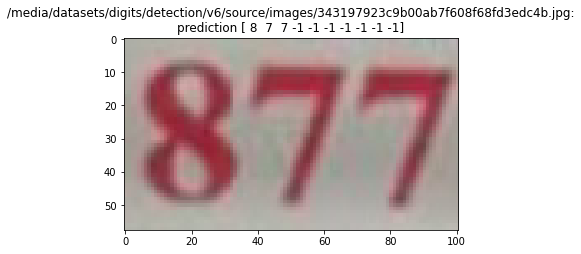

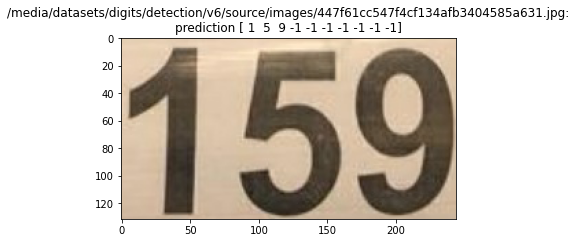

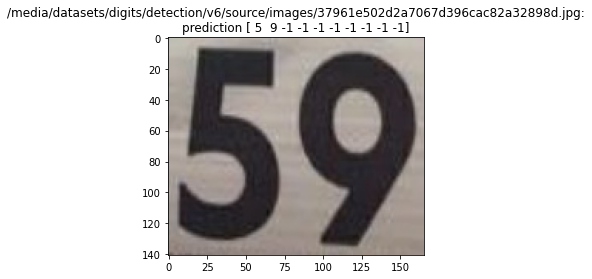

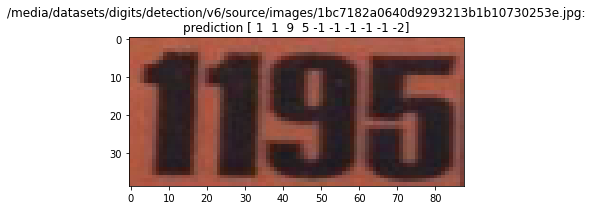

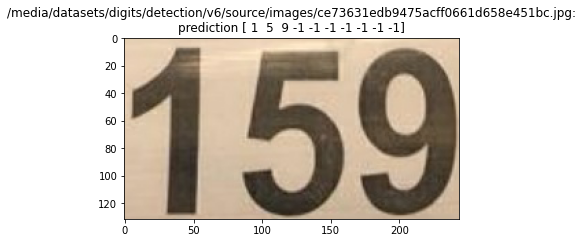

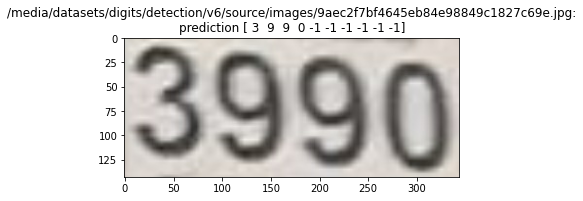

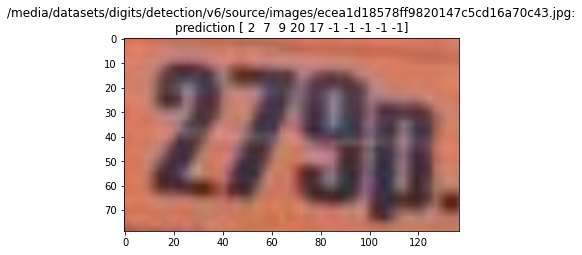

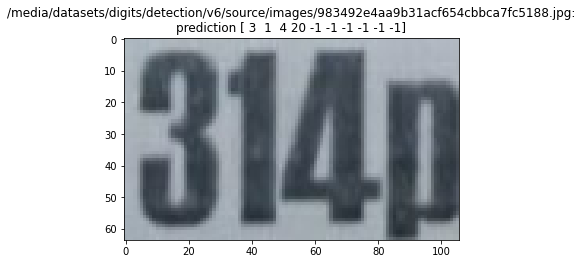

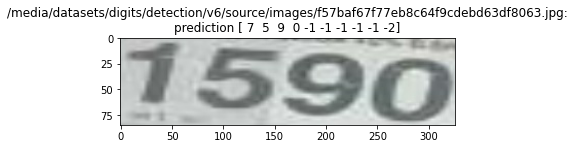

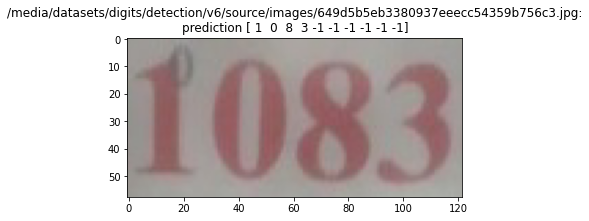

In [44]:
# visualizing predictions on real data
samples_num = 10

for sample_fname in sample_fnames[:samples_num]:
    img_path = os.path.join(ref_media_path, sample_fname)
    predict_image(img_path, show_result=True)  

In [45]:
tf.keras.models.save_model(prediction_model, MODEL_PATH)

In [46]:
# checking model load
predictor = tf.keras.models.load_model(MODEL_PATH)

In [47]:
predictor.output[0]


<KerasTensor: shape=(10,) dtype=int64 (created by layer 'tf.__operators__.getitem')>

In [74]:
# adding inputs and outputs info to profile for tfserving inference
profile_branch = MODEL_PROFILE["export_targets"]["saved_model"]
profile_branch["export"] = True
profile_branch["path"] = MODEL_PATH



# input info
_dtype = "uint8" if predictor.inputs[0].dtype == tf.uint8 else "float32"
_name = predictor.inputs[0].name
_batch_sz, _hight, _width, _channels = predictor.inputs[0].shape

input_info = {
                        "name": _name,
                        "description": "Image input, any shape, 3 channels, all preprocessing is included in the graph",
                        "tensor_index": 0,
                        "dtype": _dtype,
                        "quantized": False,
                        "quantization_options":{
                            
                        },
                        "shape":{
                            "batch_size": _batch_sz,
                            "width": _width,
                            "height": _hight,
                            "channels": _channels
                        },
                        "preprocessing":{                
                            "active": False,
                            "build_in": True,
                            "options":{
                                
                            }
                        }
                    }

if len(profile_branch["options"]["inference_options"]["inputs"]) != 0:
    profile_branch["options"]["inference_options"]["inputs"].clear()

profile_branch["options"]["inference_options"]["inputs"].append(input_info)

# output info
_dtype = predictor.outputs[0].dtype
_name = predictor.outputs[0].name
_batch_sz = 1
# _batch_sz, _hight, _width, _channels = predictor.outputs[0].shape

output_info = {
                        "name": "result_vector",
                        "description": "Result vector. -1 value means empty value",
                        "tensor_index": 0,
                        "dtype": _dtype.name,
                        "quantized": False,
                        "quantization_options":{
                            
                        },
                        "shape":{
                            "batch_size": _batch_sz,
                            "width": _width,
                            "height": _hight,
                            "channels": _channels
                        },
                        "preprocessing":{                
                            "active": False,
                            "build_in": True,
                            "options":{
                                
                            }
                        }
                    }

if len(profile_branch["options"]["inference_options"]["outputs"]) != 0:
    profile_branch["options"]["inference_options"]["outputs"].clear()
profile_branch["options"]["inference_options"]["outputs"].append(output_info)



# Exporting to TFLite

In [75]:
# checking average image size in dataset
# avr_h = 0
# avr_w = 0

# for sample_fname in sample_fnames:
#     img_path = os.path.join(ref_media_path, sample_fname)
#     img = img_load(img_path)
#     avr_h += img.shape[0]
#     avr_w += img.shape[1]

    
# avr_h /= len(sample_fnames)
# avr_w /= len(sample_fnames)

# print(avr_h, avr_w)
# print(avr_w/avr_h)

In [76]:
TFLITE_MODEL_NAME = f"{MODEL_NAME}.tflite"
TFLITE_SAVE_PATH = os.path.join(MODEL_PATH, TFLITE_MODEL_NAME)

In [77]:
INF_INPUT_HIGHT = 170
INF_INPUT_WIDTH = 320
INF_BATCH_SIZE = 1
INF_CHANNELS = 3

In [78]:
TFLITE_PROFILE = {
    "name": MODEL_PROFILE["name"],
    "input_shape": {
        "height": INF_INPUT_HIGHT,
        "width": INF_INPUT_WIDTH,
        "channels": INF_CHANNELS
    },
    "date": MODEL_PROFILE["date"],    
    "task": MODEL_PROFILE["task"],
    "version": MODEL_PROFILE["version"],
    "description": MODEL_PROFILE["description"],
    "classes": MODEL_PROFILE["metadata"]["classes"],
    "is_quantized": False,    
    "max_characters" : TARGET_MAX_CHARACTERS    
}


In [79]:
TFLITE_PROFILE

{'name': 'ctc_digit_ocr',
 'input_shape': {'height': 170, 'width': 320, 'channels': 3},
 'date': 'Wed Jul  6 15:53:07 2022',
 'task': 'OCR',
 'version': 2,
 'description': '\nPrice tag digit recognition OCR:  \nserver and mobile use - oriented\nbased on CTC Loss  \nTrained on price characters\\symbols from price tags (real and artificial images)\n',
 'classes': {0: ' ',
  1: '0',
  2: '1',
  3: '2',
  4: '3',
  5: '4',
  6: '5',
  7: '6',
  8: '7',
  9: '8',
  10: '9',
  11: ',',
  12: '/',
  13: '*',
  14: '+',
  15: '-',
  16: '%',
  17: '=',
  18: '.',
  19: ':',
  20: ';',
  21: 'p'},
 'is_quantized': False,
 'max_characters': 10}

In [80]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb


def export_tf_lite_model(model_profile=MODEL_PROFILE, 
                         tflite_profile=TFLITE_PROFILE, 
                         add_metadata=True):    
    
    saved_model_path = model_profile["path"]    
#     print(saved_model_path)
           
    saved_model = tf.saved_model.load(saved_model_path)
    concrete_func = saved_model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    
    # updating model input shape
    tflite_model_input_shape = (
                                INF_BATCH_SIZE, 
                                INF_INPUT_HIGHT, 
                                INF_INPUT_WIDTH, 
                                INF_CHANNELS
                                )        
    
    concrete_func.inputs[0].set_shape(tflite_model_input_shape)
    print(f'updating model input shape to: {concrete_func.inputs[0]}')        
    
    # converting to TFLite
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

    converter.allow_custom_ops = True
    converter.experimental_new_converter = True

    converter.target_spec.supported_ops = [        
        tf.lite.OpsSet.SELECT_TF_OPS,
        tf.lite.OpsSet.TFLITE_BUILTINS,
    #         tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    #             tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8,
    ]

    tflite_model = converter.convert()
    
    # saving TFLite model    
    with open(TFLITE_SAVE_PATH, "wb") as tflite_model_file:
        tflite_model_file.write(tflite_model)    
    print(f'Exported model to {TFLITE_SAVE_PATH} (model size: {sys.getsizeof(tflite_model)} bytes)')
    
    
    # checking loading and signature
    interpreter = tf.lite.Interpreter(model_content=tflite_model)

    # Get input and output tensors.
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    print(f"Model inputs: {input_details}\n Model outputs: {output_details}")
    
    # adding metadata and tflite model profile 
    if add_metadata:
        # Creates model info.
        model_meta = _metadata_fb.ModelMetadataT()
        model_meta.name = model_profile["name"]
        model_meta.description = model_profile["description"]
        model_meta.version = str(model_profile["version"])
        model_meta.author = model_profile["author"]
        model_meta.license = model_profile["license"]

        # Creates input info.
        input_meta = _metadata_fb.TensorMetadataT()

        input_meta.name = "input"
        input_meta.description = (
            "Input image , with three RGB channels  per pixel. Input dtype: uint8. Not normalized"
            )
        
        #Creates outputs info:        
        """
        indexes
        0 result byte string       
        """        

        # output 0 - result_string
        output_meta_0 = _metadata_fb.TensorMetadataT()
        output_meta_0.name = "result_vector"
        output_meta_0.description = "Result vector. -1 value means empty value"       
                
        tflite_profile_path = f"{MODEL_PATH}/{tflite_profile['name']}.json"
        
        print(f"writing tflite profile: {tflite_profile_path}")
        with open(tflite_profile_path, 'w') as f:
            json.dump(tflite_profile, f, indent=4, sort_keys=True)

        tflite_profile_file = _metadata_fb.AssociatedFileT()
        tflite_profile_file.name = os.path.basename(tflite_profile_path)
        tflite_profile_file.description = "CTC OCR model metadata"
        tflite_profile_file.type = _metadata_fb.AssociatedFileType.DESCRIPTIONS
        model_meta.associatedFiles = [tflite_profile_file]

        # Creates subgraph info.
        subgraph = _metadata_fb.SubGraphMetadataT()
        subgraph.inputTensorMetadata = [input_meta]
        subgraph.outputTensorMetadata = [
            output_meta_0 
        ]
        model_meta.subgraphMetadata = [subgraph]

        b = flatbuffers.Builder(0)
        b.Finish(model_meta.Pack(b), _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
        metadata_buf = b.Output()

        
        # writing metadata        
        source_model_fname = TFLITE_SAVE_PATH
        target_model_fname = TFLITE_SAVE_PATH    
        
        print(f"exporting tflite model with metadata... {target_model_fname}")
        tflite_model = open(source_model_fname, "rb").read()        
        save_path = target_model_fname
        
        populator = _metadata.MetadataPopulator.with_model_file(save_path)
        populator.load_metadata_buffer(metadata_buf)
        populator.load_associated_files([tflite_profile_path])
        populator.populate()
        
        displayer = _metadata.MetadataDisplayer.with_model_file(TFLITE_SAVE_PATH)
        print(f"Added metadata to tflite model: \n {displayer.get_metadata_json()}")
        print(f"Attached files to tflite model : {displayer.get_packed_associated_file_list()}" )
        
    print("Done!")

In [81]:
export_tf_lite_model()

updating model input shape to: Tensor("input:0", shape=(1, 170, 320, 3), dtype=uint8)
Exported model to /media/models/ctc_digit_ocr/2/ctc_digit_ocr.tflite (model size: 1530089 bytes)
Model inputs: {'name': 'input', 'index': 0, 'shape': array([  1, 170, 320,   3], dtype=int32), 'shape_signature': array([  1, 170, 320,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
 Model outputs: {'name': 'Identity', 'index': 109, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
writing tflite profile: /media/models/ctc_digit_ocr/2/ctc_digit_ocr.json
exporting tflite mo

### TFLite inference test

In [82]:
# checking loading and signature
interpreter = tf.lite.Interpreter(model_path=TFLITE_SAVE_PATH)

# Get input and output tensors.
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(f"input_details: \n{input_details}")
print('*********************************')
print(f"output_details: \n{output_details}")
interpreter.allocate_tensors()

input_details: 
{'name': 'input', 'index': 0, 'shape': array([  1, 170, 320,   3], dtype=int32), 'shape_signature': array([  1, 170, 320,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
*********************************
output_details: 
{'name': 'Identity', 'index': 109, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.int64'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


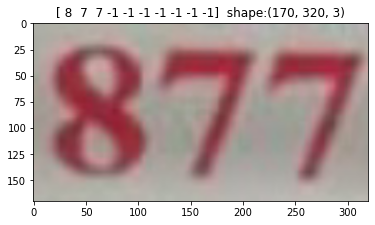

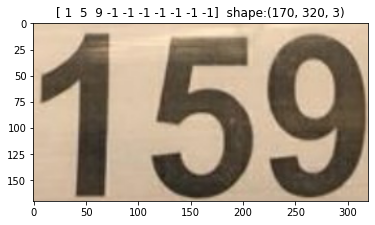

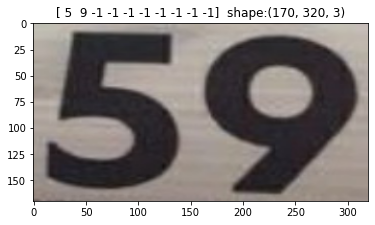

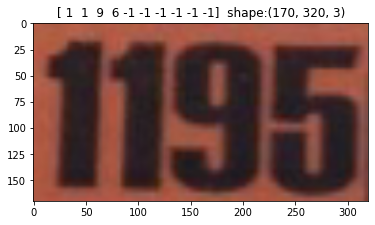

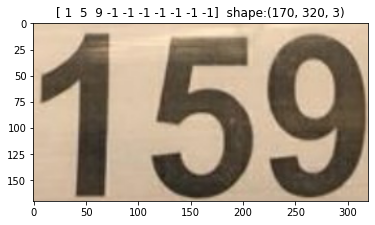

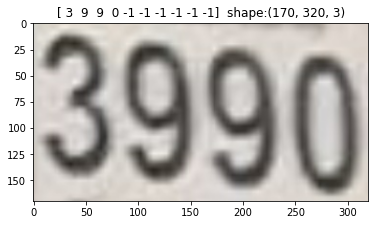

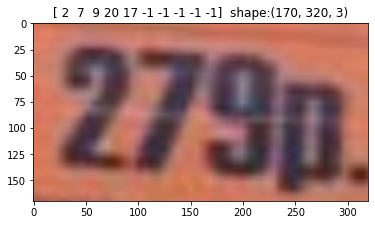

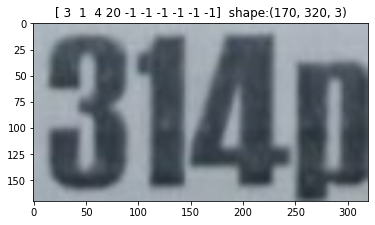

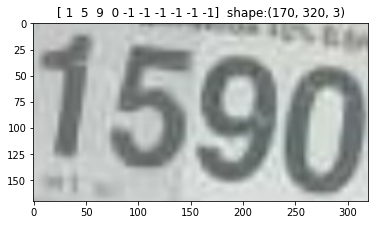

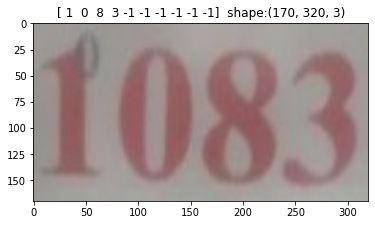

inference time (single img): 0.1570373773574829 sec, 6.367910728180214 img/sec


In [83]:
# tflite model benchmark
samples_num = 10
t1 = time.time()
show_results = True

for sample_fname in sample_fnames[:samples_num]:
    img_path = os.path.join(ref_media_path, sample_fname)
    img = img_load(img_path)   
        
    h = img.shape[0]
    w = img.shape[1]    
    
    img = tf.image.resize(img, (INF_INPUT_HIGHT, INF_INPUT_WIDTH))
    
    img = img[tf.newaxis, ...]
    img = tf.cast(img, tf.uint8)
    
#     interpreter.resize_tensor_input(input_details['index'], (1,h,w,3))
#     interpreter.allocate_tensors()
    interpreter.set_tensor(input_details["index"], img)
    interpreter.invoke()   
    result_byte_str = interpreter.get_tensor(output_details['index'])
#     print(result_byte_str.dtype)
    
    if show_results:        
        fresult = result_byte_str[0]
        show_img(img[0], title=fresult)
    
t2 = time.time()
inference_time = (t2 - t1)
img_num = len(sample_fnames)


print(f"inference time (single img): {inference_time / samples_num} sec, {samples_num / inference_time} img/sec")

In [84]:
# saving model profile
print(f'Saving model profile {MODEL_PROFILE_PATH}', end=' ')
with open(MODEL_PROFILE_PATH, 'w') as f:
    json.dump(MODEL_PROFILE, f, indent=4, sort_keys=True)
print('Done!')

Saving model profile /media/models/ctc_digit_ocr/2/profile.json Done!
